# Imports

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from numpy import log
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot

c:\users\brian\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Create Train and Test Data

In [3]:
df = pd.read_csv("./jpm_daily_close.csv",index_col=0)
df['datetime']=pd.to_datetime(df['datetime'])
df=df.dropna().reset_index(drop=True)

df.index=pd.to_datetime(df['datetime'])

train = df.loc[df['datetime']<=pd.datetime(2019,1, 27)]
test = df.loc[df['datetime']>pd.datetime(2019,1, 27)]

df=df.drop('datetime',axis=1)
train=train.drop('datetime',axis=1)
test=test.drop('datetime',axis=1)

c:\users\brian\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys
c:\users\brian\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [4]:
train.head()

,value_CAC40,value_DAX30,Open_dowjones,High_dowjones,Low_dowjones,price,Volume_dowjones,value_hangseng,Open_nasdaq,High_nasdaq,...,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
datetime,,,,,,,,,,,,,,,,,,,,,
2011-02-15,4110.339800,7400.0400,4193.240234,4212.509766,4157.140137,4190.729980,3.926860e+09,22899.779300,2809.020020,2813.129883,...,4129.994757,4138.513205,4160.217663,21.704458,41.672530,4213.339818,4046.649696,4191.781642,4189.729980,8.340869
2011-02-16,4151.259800,7414.2998,4189.620117,4237.089844,4175.370117,4212.609863,1.966450e+09,23156.970700,2815.090088,2828.189941,...,4134.406657,4144.561389,4168.342464,23.781075,44.559497,4223.525652,4045.287662,4205.667123,4211.609863,8.346075
2011-02-17,4152.310100,7405.5098,4212.169922,4241.990234,4187.149902,4224.580078,1.966450e+09,23301.839800,2816.120117,2835.199951,...,4140.611898,4151.044009,4177.052881,26.008872,47.016501,4234.644900,4046.578896,4218.275760,4223.580078,8.348912
2011-02-18,4157.140100,7426.8101,4224.669922,4254.569824,4201.580078,4237.169922,1.162310e+09,23595.240200,2833.350098,2840.510010,...,4147.809035,4157.973310,4186.354495,28.381185,49.379394,4246.567824,4049.050247,4230.871868,4236.169922,8.351887
2011-02-19,4137.230133,7391.8101,4206.967407,4247.902343,4183.642578,4216.342407,1.202428e+09,23558.633433,2823.872559,2832.427491,...,4146.800448,4157.973310,4186.354495,28.381185,49.399801,4245.547768,4048.053128,4230.871868,4215.342407,8.346924


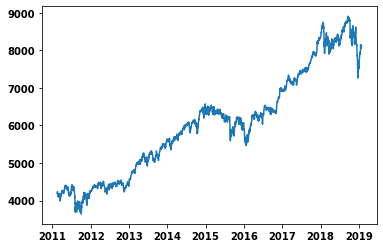

In [5]:
# plt.xlabel("Date")
# plt.ylabel("#Passengers")
plt.plot(train['price'])

Checks if series is stationary

Perform Dicky-Fuller Test

In [6]:
#p-value > .05 DATA IS NON-STATIONARY

In [7]:
print('Result of Dicky=Fuller Test')
dftest = adfuller(train['price'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['ADF Statistic', 'p-value', '#Lags Used', '#Observations Used'])

for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Result of Dicky=Fuller Test
ADF Statistic             -0.614124
p-value                    0.867759
#Lags Used                11.000000
#Observations Used      2892.000000
Critical Value (1%)       -3.432613
Critical Value (5%)       -2.862540
Critical Value (10%)      -2.567302
dtype: float64


In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    # Determinign rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    # Plot rolling statistics

    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    print('Result of Dicky=Fuller Test')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['ADF Statistic', 'p-value', '#Lags Used', '#Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

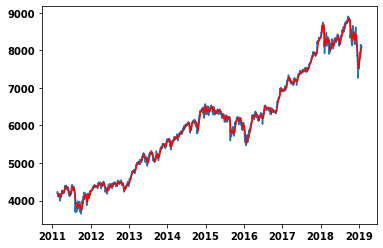

In [10]:
# Estimating trend

indexed_data = train['price']
moving_average = indexed_data.rolling(window=12).mean()
moving_std = indexed_data.rolling(window=12).mean()

plt.plot(indexed_data)
plt.plot(moving_average, color='red')

In [11]:
dataset_minus_moving_average = indexed_data - moving_average
dataset_minus_moving_average.dropna(inplace=True)
dataset_minus_moving_average.head(12)

datetime
2011-02-26   -31.849060
2011-02-27   -18.222066
2011-02-28    -3.643698
2011-03-01   -61.542847
2011-03-02   -41.375325
2011-03-03    32.926361
2011-03-04     4.928701
2011-03-05     0.435649
2011-03-06    -5.135803
2011-03-07   -13.985006
2011-03-08    40.418477
2011-03-09    43.594055
Name: price, dtype: float64

In [12]:
dataset_minus_moving_average

datetime
2011-02-26   -31.849060
2011-02-27   -18.222066
2011-02-28    -3.643698
2011-03-01   -61.542847
2011-03-02   -41.375325
                ...    
2019-01-23    61.746176
2019-01-24    70.917141
2019-01-25    85.983886
2019-01-26    51.334988
2019-01-27    20.108032
Name: price, Length: 2893, dtype: float64

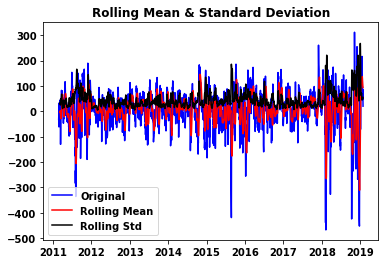

Result of Dicky=Fuller Test
ADF Statistic          -1.291465e+01
p-value                 3.989692e-24
#Lags Used              1.500000e+01
#Observations Used      2.877000e+03
Critical Value (1%)    -3.432625e+00
Critical Value (5%)    -2.862545e+00
Critical Value (10%)   -2.567305e+00
dtype: float64


In [13]:
test_stationarity(dataset_minus_moving_average)

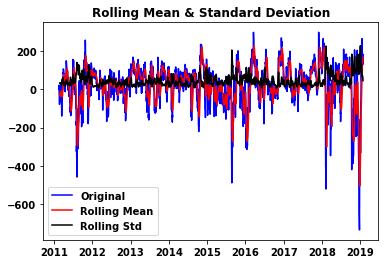

Result of Dicky=Fuller Test
ADF Statistic          -9.363047e+00
p-value                 7.730341e-16
#Lags Used              9.000000e+00
#Observations Used      2.894000e+03
Critical Value (1%)    -3.432612e+00
Critical Value (5%)    -2.862539e+00
Critical Value (10%)   -2.567302e+00
dtype: float64


In [14]:
dataset_ewm = indexed_data.ewm(halflife=12, min_periods=0, adjust=True).mean()
dataset_minus_ewm = indexed_data - dataset_ewm
test_stationarity(dataset_minus_ewm)

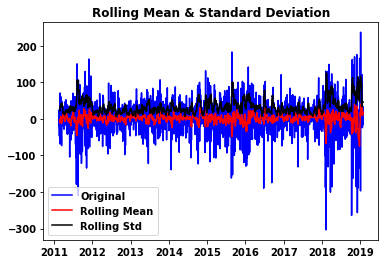

Result of Dicky=Fuller Test
ADF Statistic          -1.722142e+01
p-value                 6.276343e-30
#Lags Used              1.000000e+01
#Observations Used      2.892000e+03
Critical Value (1%)    -3.432613e+00
Critical Value (5%)    -2.862540e+00
Critical Value (10%)   -2.567302e+00
dtype: float64


In [15]:
dataset_first_order_diff = indexed_data - indexed_data.shift()
dataset_first_order_diff.dropna(inplace=True)
test_stationarity(dataset_first_order_diff)

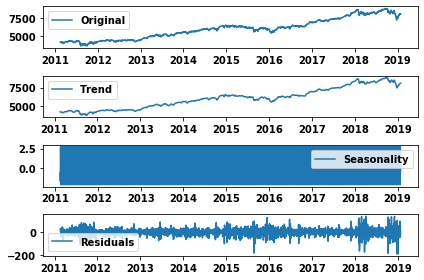

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexed_data)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexed_data, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

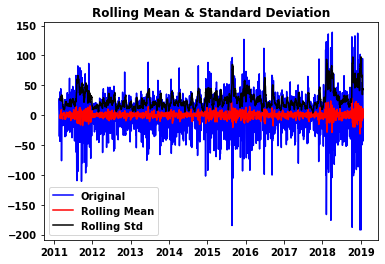

Result of Dicky=Fuller Test
ADF Statistic          -1.751645e+01
p-value                 4.307953e-30
#Lags Used              2.800000e+01
#Observations Used      2.869000e+03
Critical Value (1%)    -3.432631e+00
Critical Value (5%)    -2.862548e+00
Critical Value (10%)   -2.567307e+00
dtype: float64


In [17]:
decomposed_data = residual
decomposed_data.dropna(inplace=True)
test_stationarity(decomposed_data)

c:\users\brian\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


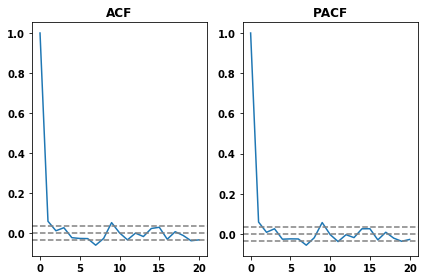

In [18]:
# ACF and PACF plots|:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(dataset_first_order_diff, nlags=20)
lag_pacf = pacf(dataset_first_order_diff, nlags=20, method='ols')

# Plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dataset_first_order_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dataset_first_order_diff)), linestyle='--', color='gray')
plt.title('ACF')

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dataset_first_order_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dataset_first_order_diff)), linestyle='--', color='gray')
plt.title('PACF')
plt.tight_layout()

c:\users\brian\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
c:\users\brian\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 4413939.7228')

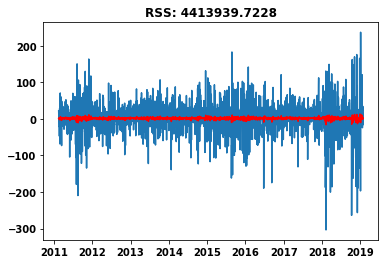

In [21]:
from statsmodels.tsa.arima_model import ARIMA

#ARIMA Model
model = ARIMA(indexed_data, order=(1,1,1))
results_ARIMA = model.fit(disp=-1)
plt.plot(dataset_first_order_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-dataset_first_order_diff)**2))

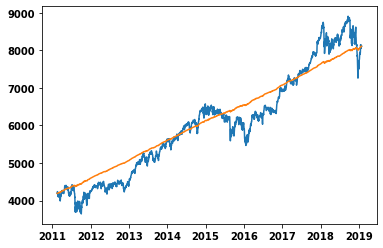

In [24]:
# Get back to the state before differening
preds = pd.Series(indexed_data.loc[indexed_data.index[0]]).append(results_ARIMA.fittedvalues).cumsum()
preds.index=indexed_data.index

# Get exponetials
predictions_ARIMA = preds

# Plot predicted data vs original data
plt.plot(train['price'])
plt.plot(predictions_ARIMA)

In [25]:
len(train['price'])

2904

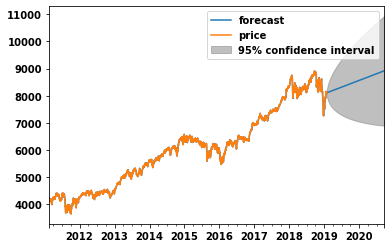

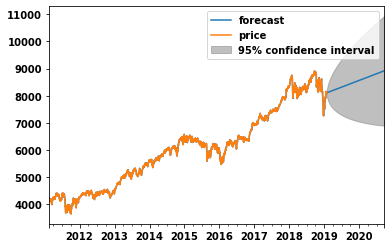

In [31]:
results_ARIMA.plot_predict(1,3500)

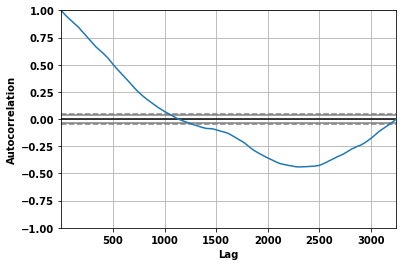

In [12]:
autocorrelation_plot(data)
# plt.figure(figsize=(12, 8))
plt.show() 


#p value can be 5

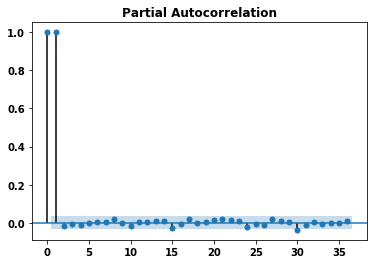

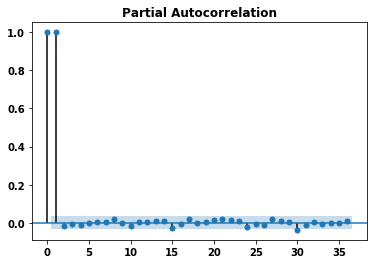

In [41]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data)
# Q CAN BE 2

In [43]:
# ARIMA(DATA, ORDER=(P,D,Q))
model = ARIMA(data, order=(5, 1, 2))
model = model.fit(disp=0)
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 3241
Model:                 ARIMA(5, 1, 2)   Log Likelihood              -16534.564
Method:                       css-mle   S.D. of innovations             39.755
Date:                Sun, 28 Feb 2021   AIC                          33087.129
Time:                        14:33:32   BIC                          33141.881
Sample:                             1   HQIC                         33106.746
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.6058      0.664      2.419      0.016       0.305       2.907
ar.L1.D.price     0.2177      1.417      0.154      0.878      -2.560       2.995
ar.L2.D.price     0.4711      1.228     

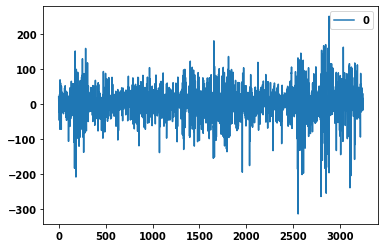

In [44]:
residuals = pd.DataFrame(model.resid)
residuals.plot()

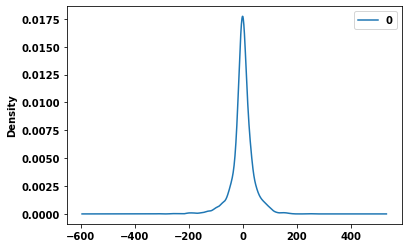

In [45]:
residuals.plot(kind='kde')

In [47]:
residuals.describe()

,0
count,3241.000000
mean,-0.002227
std,39.761515
min,-313.382840
25%,-14.114485
50%,0.116653
75%,16.079391
max,249.936547


In [33]:
X = df.price.values
train_indices = int(len(X) * 0.80)
train, test = X[0:train_indices], X[train_indices:len(X)]
result = [x for x in train]
predictions = list()
for idx in range(len(test)):
  model = ARIMA(result, order=(1,1,1))
  fit_model = model.fit(disp=0)
  output = fit_model.forecast()
  y_pred = output[0]
  predictions.append(y_pred)
  result.append(test[idx])

In [ ]:
error = mean_squared_error(test, predictions)
print(f'Test MSE: {error:.3}')

In [ ]:
plt.figure(figsize=(12, 8), dpi=100)
plt.plot(test, label='Test')
plt.plot(predictions, color='red', label='Prediction')
plt.xlabel('Days')
plt.ylabel('$')
plt.title('ARIMA forecast JPMorgan close')
plt.legend()
plt.show()